In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() != None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
#     print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [21]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [22]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [23]:
dfhw=pd.read_csv("data/01_heights_weights_genders.csv")
print(dfhw.shape)
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [24]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

247

In [25]:
df.shape[0]

500

In [26]:
itrain, itest = train_test_split(np.arange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([ True,  True,  True, False, False,  True, False,  True, False,
       False])

using mask
BEST {'C': 0.01} 0.93 {'mean_fit_time': array([0.00132065, 0.0019443 , 0.00108113, 0.00185442, 0.00159755,
       0.00073104, 0.00356102, 0.0004674 ]), 'std_fit_time': array([0.0004767 , 0.00139415, 0.00170777, 0.00190099, 0.00195659,
       0.00146208, 0.00615493, 0.00093479]), 'mean_score_time': array([0.00040216, 0.00020885, 0.        , 0.        , 0.0008111 ,
       0.00020728, 0.        , 0.00020003]), 'std_score_time': array([0.0004926 , 0.00041771, 0.        , 0.        , 0.0016222 ,
       0.00041456, 0.        , 0.00040007]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.93442623, 0.95081967, 0.95081967, 0.95081967, 0.95081967,
       0.95081967, 0.95081967, 0.95081967]), 'spl

c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files (x86)\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed

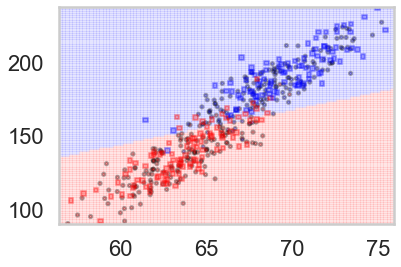

In [27]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [28]:
clflog.predict(Xtest)

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1])

In [29]:
clflog.predict_proba(Xtest)

array([[5.38205696e-01, 4.61794304e-01],
       [6.61570349e-04, 9.99338430e-01],
       [3.89142418e-01, 6.10857582e-01],
       [6.72031642e-01, 3.27968358e-01],
       [1.37865964e-01, 8.62134036e-01],
       [4.98467100e-02, 9.50153290e-01],
       [9.72942479e-01, 2.70575212e-02],
       [1.73689005e-03, 9.98263110e-01],
       [6.37842726e-02, 9.36215727e-01],
       [1.14265887e-02, 9.88573411e-01],
       [1.52874534e-01, 8.47125466e-01],
       [9.57993336e-02, 9.04200666e-01],
       [9.80522867e-01, 1.94771328e-02],
       [1.33450562e-01, 8.66549438e-01],
       [9.92374866e-01, 7.62513356e-03],
       [8.69160676e-01, 1.30839324e-01],
       [9.97040429e-01, 2.95957100e-03],
       [9.82435468e-01, 1.75645324e-02],
       [3.94759750e-04, 9.99605240e-01],
       [6.11997455e-02, 9.38800255e-01],
       [9.99614807e-01, 3.85192973e-04],
       [9.88964740e-01, 1.10352595e-02],
       [9.87808411e-01, 1.21915887e-02],
       [6.52033836e-03, 9.93479662e-01],
       [5.772499

In [30]:
clflog.predict_proba(Xtest)[:,1]

array([4.61794304e-01, 9.99338430e-01, 6.10857582e-01, 3.27968358e-01,
       8.62134036e-01, 9.50153290e-01, 2.70575212e-02, 9.98263110e-01,
       9.36215727e-01, 9.88573411e-01, 8.47125466e-01, 9.04200666e-01,
       1.94771328e-02, 8.66549438e-01, 7.62513356e-03, 1.30839324e-01,
       2.95957100e-03, 1.75645324e-02, 9.99605240e-01, 9.38800255e-01,
       3.85192973e-04, 1.10352595e-02, 1.21915887e-02, 9.93479662e-01,
       9.94227500e-01, 9.49774253e-01, 9.91386270e-01, 2.59855256e-02,
       5.36338504e-02, 9.94290093e-01, 9.99114182e-01, 9.86918812e-01,
       9.98033785e-01, 4.10623494e-01, 9.99727906e-01, 6.13104286e-03,
       6.40556968e-01, 9.99917190e-01, 4.45396599e-03, 9.43922893e-01,
       1.19830667e-01, 6.89517743e-01, 1.67134994e-01, 8.57930499e-01,
       9.64580645e-01, 5.46545760e-02, 9.99824459e-01, 3.35281477e-02,
       5.57694055e-03, 6.13965563e-01, 9.91313119e-01, 9.94003792e-01,
       5.66893504e-01, 9.90577386e-01, 9.67876576e-01, 9.73679038e-01,
      

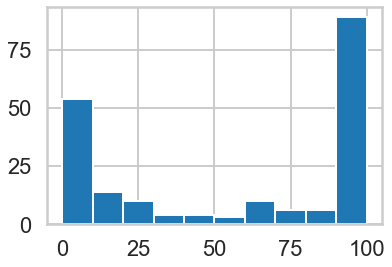

In [31]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

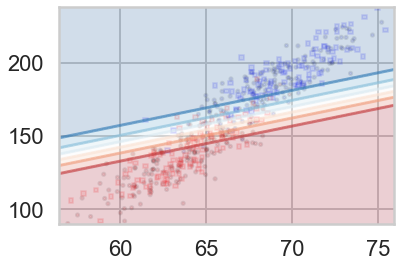

In [32]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [33]:
clflog.score(Xtest, ytest)

0.91

using mask
BEST {'C': 0.001} 0.9366666666666666 {'mean_fit_time': array([1.42602921e-03, 1.99508667e-04, 1.31115913e-03, 4.54759598e-03,
       3.02828789e-02, 1.47063541e-01, 8.07515192e-01]), 'std_fit_time': array([1.51703875e-03, 3.99017334e-04, 1.45657306e-03, 1.27151796e-03,
       7.57583531e-03, 2.63368132e-02, 5.05933073e-01]), 'mean_score_time': array([0.00000000e+00, 6.36005402e-04, 1.99556351e-04, 5.98621368e-04,
       2.57544518e-03, 0.00000000e+00, 4.22477722e-05]), 'std_score_time': array([0.00000000e+00, 1.27201080e-03, 3.99112701e-04, 4.88772355e-04,
       5.15089035e-03, 0.00000000e+00, 8.44955444e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.96721311, 0.95081967, 0.96721311, 0.96721311, 0.96721311

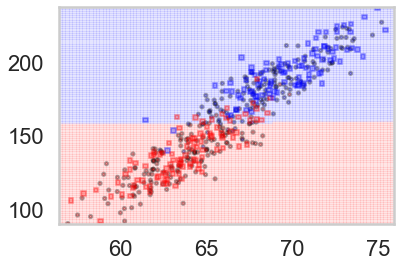

In [34]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [35]:
clfsvm.decision_function(Xtest)

array([ 0.19188002,  5.74291268,  0.39391601, -0.63058004,  1.59218072,
        2.59448988, -2.82257561,  4.85871196,  2.49612445,  2.39761398,
        0.97423322,  0.24925083, -2.72022036,  1.4306504 , -3.57717819,
       -1.93558264, -4.56221901, -3.68626952,  5.7322874 ,  2.45473587,
       -6.10878555, -4.39389987, -2.88400787,  3.36690691,  3.5963447 ,
        1.97157186,  3.62279754, -2.54810934, -2.67928095,  3.25297582,
        5.04134948,  3.46468032,  4.67473222,  0.21783039,  6.17257788,
       -3.49881356, -0.27366112,  7.27601697, -4.57119117,  1.75590977,
       -1.58255242,  0.464553  , -1.68054008,  1.59977071,  2.60738896,
       -2.86630935,  6.68250874, -2.33219747, -3.99681533, -0.41502924,
        3.06104695,  3.23575329,  0.65767761,  3.45564369,  2.00997749,
        2.4554296 ,  2.92026107,  3.15793094, -0.5748847 ,  3.44805677,
        0.60173301,  0.70444337,  0.34803693,  5.75146804,  2.35741189,
       -3.10929124, -3.15677834, -0.76752128,  3.16168943,  0.87

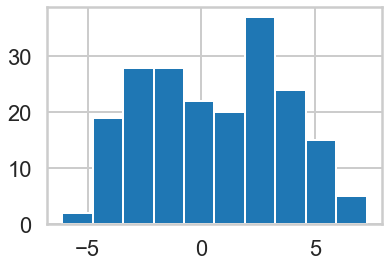

In [36]:
plt.hist(clfsvm.decision_function(Xtest));

c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

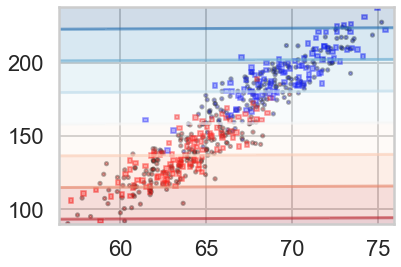

In [37]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [39]:
def plot_svc_decision_function(clf, ax=None):
    
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[56.47527896 89.84178426].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

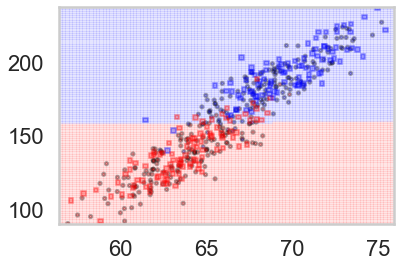

In [40]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

In [41]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[85, 17],
       [ 1, 97]], dtype=int64)

In [43]:
from sklearn.metrics import classification_report
print (classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       102
           1       0.85      0.99      0.92        98

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



In [44]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [45]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[54, 48],
       [ 0, 98]], dtype=int64)

In [48]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

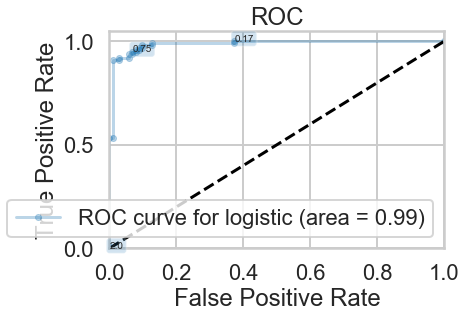

In [49]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

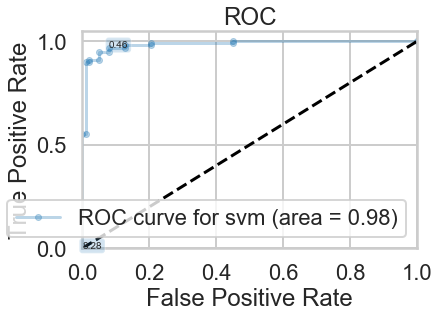

In [50]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)